# New idea:
1. Train site-specific supervised classifier models for S1 classification
2. Maybe train another larger model on these outputs from the individual models accompanied by outside metadata for classifying?


Regardless, need to use the mode of the entire time series of the outputs of the models as the water mask for the isce2 processing. Need to resample up to the same resolution as the Interferograms.

In [1]:
import os
import random
from datetime import datetime
from itertools import product
import rasterio
from rasterio import windows
from shapely.geometry import box
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from scipy.ndimage import binary_closing
import dask
from dask.distributed import Client
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, Conv2D, UpSampling2D, Concatenate, MaxPooling2D, Dropout, BatchNormalization, Conv2DTranspose, concatenate, Flatten, Dense, UpSampling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-11-14 15:28:43.102230: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 15:28:43.102840: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-14 15:28:43.105009: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-14 15:28:43.110712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731619723.119979  137411 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731619723.12

# Functions

In [2]:
def get_labels(labelpath):
    majority_ims = [os.path.join(labelpath, f'majority/{file}') for file in os.listdir(os.path.join(labelpath, f'majority')) if file.endswith('.tif')]
    majority_ims = sorted(majority_ims, key=lambda x: datetime.strptime(x[-14:-4], '%Y-%m-%d'))

    return majority_ims

def get_grd(grdpath):
    orig_ims = [os.path.join(grdpath, file) for file in os.listdir(grdpath) if file.endswith('.tif')]
    orig_ims = sorted(orig_ims, key=lambda x: datetime.strptime(x[-14:-4], '%Y-%m-%d'))

    return orig_ims

def get_glcm(glcmpath):
    orig_glcms = [os.path.join(glcmpath, file) for file in os.listdir(glcmpath) if file.endswith('.tif')]
    orig_glcms = sorted(orig_glcms, key=lambda x: datetime.strptime(x[-14:-4], '%Y-%m-%d'))

    return orig_glcms
def find_closest_dates(labels, backscatter_ims, glcm_ims, max_days=12):
    closest_dates = []  # To store the closest matches for each label

    # Iterate through each label
    for label in labels:
        label_date = datetime.strptime(label[-14:-4], '%Y-%m-%d')  # Extract date from label
        min_diff = max_days + 1  # Initialize minimum difference as larger than max_days
        closest_backscatter = None  # To store the closest backscatter match
        closest_glcm = None  # To store the closest GLCM match

        # Iterate through both backscatter and GLCM images
        for backscatter, glcm in zip(backscatter_ims, glcm_ims):
            backscatter_date = datetime.strptime(backscatter[-14:-4], '%Y-%m-%d')  # Extract date from backscatter
            glcm_date = datetime.strptime(glcm[-14:-4], '%Y-%m-%d')  # Extract date from GLCM

            # Calculate the absolute difference in days
            day_difference = abs((backscatter_date - label_date).days)

            # Check if the difference is within max_days and closer than the current minimum
            if day_difference <= max_days and day_difference < min_diff:
                min_diff = day_difference
                closest_backscatter = backscatter
                closest_glcm = glcm

        # Store the closest matches for the current label
        closest_dates.append((label, closest_backscatter, closest_glcm))

    return closest_dates

def stack_data(filtered_data, unlab_s1, unlab_glcm):
    X_train = []
    y_train = []
    X_unlabeled = []

    for set in filtered_data:
        with rasterio.open(set[2]) as glcm_src:
            VV_contrast = glcm_src.read(1).astype(np.float32)
            # VV_asm = glcm_src.read(2).astype(np.float32)
            VV_diss = glcm_src.read(3).astype(np.float32)
            # VV_idm = glcm_src.read(4).astype(np.float32)
            VV_corr = glcm_src.read(5).astype(np.float32)
            # VV_var = glcm_src.read(6).astype(np.float32)
            VV_ent = glcm_src.read(7).astype(np.float32)
            VH_contrast = glcm_src.read(8).astype(np.float32)
            # VH_asm = glcm_src.read(9).astype(np.float32)
            VH_diss = glcm_src.read(10).astype(np.float32)
            # VH_idm = glcm_src.read(11).astype(np.float32)
            VH_corr = glcm_src.read(12).astype(np.float32)
            # VH_var = glcm_src.read(13).astype(np.float32)
            VH_ent = glcm_src.read(14).astype(np.float32)


            VV_contrast = (VV_contrast - VV_contrast.min()) / (VV_contrast.max() - VV_contrast.min())
            # VV_asm = (VV_asm- VV_asm.min()) / (VV_asm.max() - VV_asm.min())
            VV_diss = (VV_diss - VV_diss.min()) / (VV_diss.max() - VV_diss.min())
            # VV_idm = (VV_idm - VV_idm.min()) / (VV_idm.max() - VV_idm.min())
            VV_corr = (VV_corr - VV_corr.min()) / (VV_corr.max() - VV_corr.min())
            # VV_var = (VV_var - VV_var.min()) / (VV_var.max() - VV_var.min())
            VV_ent = (VV_ent - VV_ent.min()) / (VV_ent.max() - VV_ent.min())
            VH_contrast = (VH_contrast - VH_contrast.min()) / (VH_contrast.max() - VH_contrast.min())
            # VH_asm = (VH_asm- VH_asm.min()) / (VH_asm.max() - VH_asm.min())
            VH_diss = (VH_diss - VH_diss.min()) / (VH_diss.max() - VH_diss.min())
            # VH_idm = (VH_idm - VH_idm.min()) / (VH_idm.max() - VH_idm.min())
            VH_corr = (VH_corr - VH_corr.min()) / (VH_corr.max() - VH_corr.min())
            # VH_var = (VH_var - VH_var.min()) / (VH_var.max() - VH_var.min())
            VH_ent = (VH_ent - VH_ent.min()) / (VH_ent.max() - VH_ent.min())
    
        with rasterio.open(set[1]) as src:
            vv = src.read(1).astype(np.float32)
            vh = src.read(2).astype(np.float32)
            rvi = src.read(3).astype(np.float32)
            sdwi = src.read(4).astype(np.float32)

            # Convert from dB to linear scale
            vv_linear = 10 ** (vv / 10)
            vh_linear = 10 ** (vh / 10)

            vv_lin_norm = (vv_linear - vv_linear.min()) / (vv_linear.max() - vv_linear.min())
            vh_lin_norm = (vh_linear - vh_linear.min()) / (vh_linear.max() - vh_linear.min())
            rvi_norm = (rvi - rvi.min()) / (rvi.max() - rvi.min())
            sdwi_norm = (sdwi - sdwi.min()) / (sdwi.max() - sdwi.min())

        s1_data = np.stack([vv_lin_norm, 
                            vh_lin_norm, 
                            rvi_norm, 
                            sdwi_norm, 
                            VV_contrast, 
                            # VV_asm,
                            VV_diss, 
                            # VV_idm,
                            VV_corr, 
                            # VV_var, 
                            VV_ent, 
                            VH_contrast, 
                            # VH_asm,
                            VH_diss, 
                            # VH_idm, 
                            VH_corr, 
                            # VH_var, 
                            VH_ent
                            ], axis=-1)

        with rasterio.open(set[0]) as src:
            s2_labels = src.read(1).astype(np.int32)
    
        X_train.append(s1_data)
        y_train.append(s2_labels)


    X_unlabeled = []

    for i, im in enumerate(unlab_s1):
        with rasterio.open(im) as src:
            vv = src.read(1).astype(np.float32)
            vh = src.read(2).astype(np.float32)
            rvi = src.read(3).astype(np.float32)
            sdwi = src.read(4).astype(np.float32)

            # Convert from dB to linear scale
            vv_linear = 10 ** (vv / 10)
            vh_linear = 10 ** (vh / 10)

            vv_lin_norm = (vv_linear - vv_linear.min()) / (vv_linear.max() - vv_linear.min())
            vh_lin_norm = (vh_linear - vh_linear.min()) / (vh_linear.max() - vh_linear.min())
            rvi_norm = (rvi - rvi.min()) / (rvi.max() - rvi.min())
            sdwi_norm = (sdwi - sdwi.min()) / (sdwi.max() - sdwi.min())

        with rasterio.open(unlab_glcm[i]) as glcm_src:
            VV_contrast = glcm_src.read(1).astype(np.float32)
            VV_asm = glcm_src.read(2).astype(np.float32)
            VV_diss = glcm_src.read(3).astype(np.float32)
            VV_idm = glcm_src.read(4).astype(np.float32)
            VV_corr = glcm_src.read(5).astype(np.float32)
            VV_var = glcm_src.read(6).astype(np.float32)
            VV_ent = glcm_src.read(7).astype(np.float32)
            VH_contrast = glcm_src.read(8).astype(np.float32)
            VH_asm = glcm_src.read(9).astype(np.float32)
            VH_diss = glcm_src.read(10).astype(np.float32)
            VH_idm = glcm_src.read(11).astype(np.float32)
            VH_corr = glcm_src.read(12).astype(np.float32)
            VH_var = glcm_src.read(13).astype(np.float32)
            VH_ent = glcm_src.read(14).astype(np.float32)


            VV_contrast = (VV_contrast - VV_contrast.min()) / (VV_contrast.max() - VV_contrast.min())
            VV_asm = (VV_asm- VV_asm.min()) / (VV_asm.max() - VV_asm.min())
            VV_diss = (VV_diss - VV_diss.min()) / (VV_diss.max() - VV_diss.min())
            VV_idm = (VV_idm - VV_idm.min()) / (VV_idm.max() - VV_idm.min())
            VV_corr = (VV_corr - VV_corr.min()) / (VV_corr.max() - VV_corr.min())
            VV_var = (VV_var - VV_var.min()) / (VV_var.max() - VV_var.min())
            VV_ent = (VV_ent - VV_ent.min()) / (VV_ent.max() - VV_ent.min())
            VH_contrast = (VH_contrast - VH_contrast.min()) / (VH_contrast.max() - VH_contrast.min())
            VH_asm = (VH_asm- VH_asm.min()) / (VH_asm.max() - VH_asm.min())
            VH_diss = (VH_diss - VH_diss.min()) / (VH_diss.max() - VH_diss.min())
            VH_idm = (VH_idm - VH_idm.min()) / (VH_idm.max() - VH_idm.min())
            VH_corr = (VH_corr - VH_corr.min()) / (VH_corr.max() - VH_corr.min())
            VH_var = (VH_var - VH_var.min()) / (VH_var.max() - VH_var.min())
            VH_ent = (VH_ent - VH_ent.min()) / (VH_ent.max() - VH_ent.min())

        s1_unlab_data = np.stack([vv_lin_norm, vh_lin_norm, rvi_norm, sdwi_norm, VV_contrast, VV_asm,VV_diss, VV_idm, VV_corr, VV_var, VV_ent, VH_contrast, VH_asm,VH_diss, VH_idm, VH_corr, VH_var, VH_ent], axis=-1)

        X_unlabeled.append(s1_unlab_data)


    return X_train, y_train, X_unlabeled

# Collect Imagery for model training

In [3]:
###################### WSL #########################
# majority_ims = get_labels('/mnt/d/SabineRS/s2classifications')
# backscatter_ims = get_grd('/mnt/d/SabineRS/GRD/3_ratio')
# glcm_ims = get_glcm('/mnt/d/SabineRS/GRD/2_registered/glcm')

###################### Linux #########################
majority_ims = get_labels('/home/wcc/Desktop/SabineRS/MSI/s2classifications')
backscatter_ims = get_grd('/home/wcc/Desktop/SabineRS/GRD/3_ratio')
glcm_ims = get_glcm('/home/wcc/Desktop/SabineRS/GRD/2_registered/glcm')

In [4]:
# pair the Sentinel-1 backscatter and glcm  with labels according to date
labeledPairs = find_closest_dates(majority_ims, backscatter_ims, glcm_ims)

# Filter out tuples that contain any None entries
# no close matches between S2 labels and S1 images
filtered_data = [entry for entry in labeledPairs if None not in entry]

In [5]:
s1matches = [set[1] for set in filtered_data]
glcmmatches = [set[2] for set in filtered_data]
s1_X = [i for i in backscatter_ims if i not in s1matches]   # unlabeled S1 data for model training
glcm_X = [i for i in glcm_ims if i not in glcmmatches]

In [6]:
# For training data

labelpaths = []
grdpaths = []
glcmpaths = []

unlabs1 = []
unlabglcm = []

for i, pair in enumerate(filtered_data):
    labelpaths.append(filtered_data[0])
    grdpaths.append(filtered_data[1])
    glcmpaths.append(filtered_data[2])

for j, im in enumerate(s1_X):
    unlabs1.append(im)
    unlabglcm.append(glcm_X[j])
    
labelseries=pd.Series(labelpaths, name='labelpaths')
grdseries = pd.Series(grdpaths, name = 'grdpaths')
glcmseries = pd.Series(glcmpaths, name='glcmpaths')
train_df=pd.concat([labelseries, grdseries, glcmseries], axis=1)

ugrdseries = pd.Series(unlabs1, name = 'grdpaths')
uglcmseries = pd.Series(unlabglcm, name='glcmpaths')
unlabel_df = pd.concat([ugrdseries, uglcmseries], axis=1)

# Data prep

In [7]:
X_train, y_train, X_unlabeled = stack_data(filtered_data, s1_X, glcm_X)

In [9]:
num_channels = 12 # 4 bands from GRD and 14 from GLCM 
num_classes = 3
img_height, img_width = X_train[0].shape[:2]  # Assuming all images have the same dimensions


X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [10]:
def batch_generator(image_patches, label_patches, batch_size):
    num_samples = len(image_patches)
    while True:  # Loop indefinitely so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_images = image_patches[offset:offset + batch_size]
            batch_labels = label_patches[offset:offset + batch_size]
            yield batch_images, batch_labels

def pad_image(image, patch_size=(256, 256)):
    pad_h = (patch_size[0] - image.shape[0] % patch_size[0]) % patch_size[0]
    pad_w = (patch_size[1] - image.shape[1] % patch_size[1]) % patch_size[1]

    # Apply padding based on the number of dimensions
    if image.ndim == 3:  # For 3D images (H, W, C)
        padded_image = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')
    elif image.ndim == 2:  # For 2D labels (H, W)
        padded_image = np.pad(image, ((0, pad_h), (0, pad_w)), mode='reflect')
    else:
        raise ValueError("Input image must be either 2D or 3D.")
        
    return padded_image, pad_h, pad_w


# Step 2: Crop the padded image back to the original size
def crop_to_original_size(image, original_shape, pad_h, pad_w):
    return image[:original_shape[0], :original_shape[1]]

def image_to_patches(image, patch_size=(256, 256)):
    patches = []
    img_height, img_width = image.shape[:2]
    patch_height, patch_width = patch_size

    # Pad the image if it's not divisible by the patch size
    padded_image, pad_h, pad_w = pad_image(image, patch_size)

    # Extract patches from the padded image
    for i in range(0, padded_image.shape[0], patch_height):
        for j in range(0, padded_image.shape[1], patch_width):
            patch = padded_image[i:i + patch_height, j:j + patch_width]
            patches.append(patch)
    
    return np.array(patches), pad_h, pad_w

def get_patches_from_images(images, labels, patch_size=(256, 256)):
    image_patches = []
    label_patches = []

    for img, lbl in zip(images, labels):
        img_patches, pad_h, pad_w = image_to_patches(img, patch_size)
        lbl_patches, _, _ = image_to_patches(lbl, patch_size)

        image_patches.extend(img_patches)
        label_patches.extend(lbl_patches)

    # Shuffle the patches in unison
    combined = list(zip(image_patches, label_patches))
    random.shuffle(combined)
    image_patches[:], label_patches[:] = zip(*combined)

    return np.array(image_patches), np.array(label_patches), pad_h, pad_w


# Step 4: Update the predict_on_large_image function to pad and crop
def predict_on_large_image(model, large_image, patch_size=(256, 256)):
    # Pad the large image
    padded_image, pad_h, pad_w = pad_image(large_image, patch_size)
    patches, _, _ = image_to_patches(padded_image, patch_size)

    # Run predictions on each patch
    predictions = []
    for patch in patches:
        patch = np.expand_dims(patch, axis=0)  # Add batch dimension
        pred = model.predict(patch)
        predictions.append(pred.squeeze())  # Remove batch dimension

    # Reassemble the patches
    num_patches_x = padded_image.shape[0] // patch_size[0]
    num_patches_y = padded_image.shape[1] // patch_size[1]
    pred_image_padded = np.block([[predictions[i * num_patches_y + j] 
                                   for j in range(num_patches_y)] 
                                  for i in range(num_patches_x)])
    
    # Crop to the original size
    pred_image = crop_to_original_size(pred_image_padded, large_image.shape, pad_h, pad_w)
    return pred_image

# Custom NN
- name could be BUNet -- Beneficial Use Network given the focus on sediment enrichment in wetlands

In [ ]:
####### TWO CLASSIFICATIONS #######

# Define the input layer (adjust input shape as needed for your Sentinel-1 data)
inputs = Input(shape=(256, 256, num_channels))  # assuming 2 channels for Sentinel-1 VH and VV

# Encoder path with batch normalization, dropout, and skip connections
c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
c1 = BatchNormalization()(c1)
c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
c1 = BatchNormalization()(c1)
c1 = Dropout(0.3)(c1)

c2 = Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2, 2))(c1)  # Downsample by a factor of 2
c2 = BatchNormalization()(c2)
c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.3)(c2)

c3 = Conv2D(128, (3, 3), activation='relu', padding='same', strides=(2, 2))(c2)  # Downsample by a factor of 2
c3 = BatchNormalization()(c3)
c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.4)(c3)

# Decoder path with upsampling and skip connections
u1 = UpSampling2D(size=(2, 2))(c3)  # Upsample to match c2
u1 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
u1 = BatchNormalization()(u1)
u1 = Concatenate()([u1, c2])  # Skip connection with c2

u2 = UpSampling2D(size=(2, 2))(u1)  # Upsample to match c1
u2 = Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
u2 = BatchNormalization()(u2)
u2 = Concatenate()([u2, c1])  # Skip connection with c1

# Final layer for binary classification with sigmoid activation
outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(u2)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with binary crossentropy for two-class segmentation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

In [13]:
####### THREE CLASSIFICATIONS #######

# Define the input layer (adjust input shape as needed for your Sentinel-1 data)
inputs = Input(shape=(256, 256, num_channels))  # assuming 18 channels for Sentinel-1 data

# Encoder path with batch normalization, dropout, and skip connections
c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
c1 = BatchNormalization()(c1)
c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
c1 = BatchNormalization()(c1)
c1 = Dropout(0.3)(c1)

c2 = Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2, 2))(c1)  # Downsample by a factor of 2
c2 = BatchNormalization()(c2)
c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.3)(c2)

c3 = Conv2D(128, (3, 3), activation='relu', padding='same', strides=(2, 2))(c2)  # Downsample by a factor of 2
c3 = BatchNormalization()(c3)
c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.4)(c3)

# Decoder path with upsampling and skip connections
u1 = UpSampling2D(size=(2, 2))(c3)  # Upsample to match c2
u1 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
u1 = BatchNormalization()(u1)
u1 = Concatenate()([u1, c2])  # Skip connection with c2

u2 = UpSampling2D(size=(2, 2))(u1)  # Upsample to match c1
u2 = Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
u2 = BatchNormalization()(u2)
u2 = Concatenate()([u2, c1])  # Skip connection with c1

# Final layer for 3-class segmentation with softmax activation
outputs = Conv2D(3, (1, 1), activation='softmax', padding='same')(u2)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with categorical crossentropy for 3-class segmentation
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │      3,488 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 256, 256,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │     18,496 │ dropout_3[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │     73,856 │ dropout_4[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 128, 128,  │          0 │ dropout_5[0][0] 

 Total params: 402,659 (1.54 MB)

 Trainable params: 401,571 (1.53 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [14]:
# Updated usage example
# Assuming images and labels are prepared as lists of arrays
patch_size = (256, 256)
batch_size = 16

# Prepare patches from images and labels
image_patches, label_patches, pad_h, pad_w = get_patches_from_images(X_train_split, y_train_split, patch_size)

# Train the model
model.fit(
    batch_generator(image_patches, label_patches, batch_size),
    steps_per_epoch=len(image_patches) // batch_size,
    epochs=5
)


Epoch 1/5


2024-11-14 15:29:22.471323: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


48/48 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.6181 - loss: 0.8362
Epoch 2/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.7036 - loss: 0.5665
Epoch 3/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.7120 - loss: 0.5435
Epoch 4/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.7204 - loss: 0.5310
Epoch 5/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.7223 - loss: 0.5238


In [16]:
preds =[]
masks =[]
closed =[]

for im in X_val_split:
    pred_image = predict_on_large_image(model, im, patch_size=(256, 256))
    preds.append(pred_image)

    maskim = pred_image.copy()
    maskim[maskim != 1] = 0
    masks.append(maskim)

    # # Apply morphological closing with a structuring element
    # closed_image = binary_closing(maskim, structure=np.ones((3, 3))).astype(int)
    # closed.append(closed_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

TypeError: Invalid shape (256, 693, 9) for image data

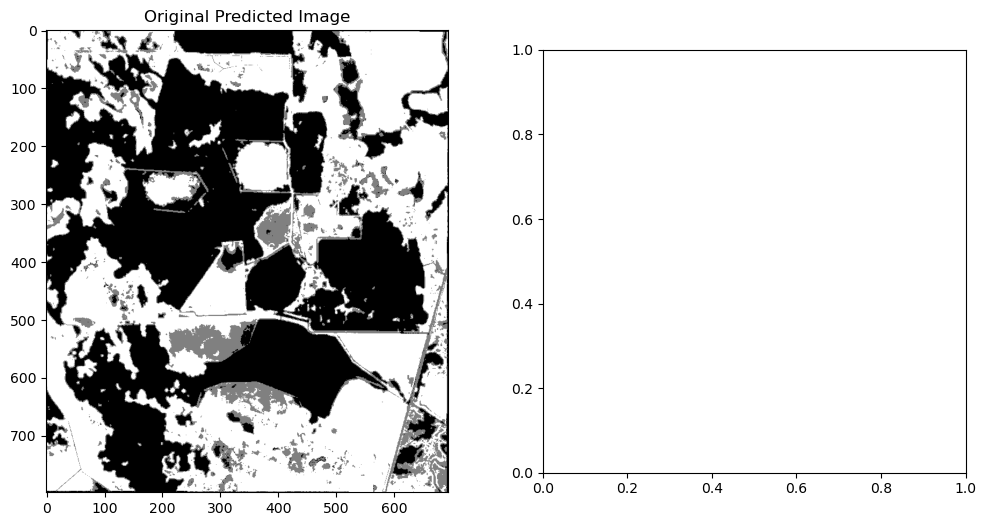

In [17]:
# Display the original and thresholded images
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(y_val_split[0], cmap='gray')
plt.title("Original Predicted Image")

# Binary mask after max entropy thresholding
plt.subplot(1, 2, 2)
plt.imshow(masks[0], cmap='gray')
plt.title("Binary Mask (Max Entropy Threshold)")
plt.show()


In [ ]:
for (pred_image, mask_image, closed_image) in zip(preds, masks, closed):
    difference_image = closed_image - mask_image

    plt.figure(figsize=(15, 10))

    plt.subplot(3, 2, 1)
    plt.imshow(pred_image, cmap='gray')
    plt.title("Predicted Image")

    plt.subplot(3, 2, 3)
    plt.imshow(mask_image, cmap='gray')
    plt.title("Masked Image (!= 1 -> 0)")

    plt.subplot(3, 2, 5)
    plt.imshow(closed_image, cmap='gray')
    plt.title("Closed Image ()")

    plt.subplot(1, 2, 2)
    plt.imshow(difference_image, cmap='coolwarm')
    plt.title("Difference (Closed - Masked)")
    plt.colorbar(label="Difference", orientation="vertical")

    plt.tight_layout()
    plt.show()

In [ ]:


# Step 1: Calculate the difference
difference_image = closed_image - mask_image

# Step 2: Visualize the images with the desired layout
plt.figure(figsize=(15, 10))

# Show predicted image
plt.subplot(3, 2, 1)
plt.imshow(pred_image, cmap='gray')
plt.title("Predicted Image")

# Show masked image
plt.subplot(3, 2, 3)
plt.imshow(mask_image, cmap='gray')
plt.title("Masked Image (!= 1 -> 0)")

# Show closed image
plt.subplot(3, 2, 5)
plt.imshow(closed_image, cmap='gray')
plt.title("Closed Image ()")

# Show difference image spanning the right side
plt.subplot(1, 2, 2)
plt.imshow(difference_image, cmap='coolwarm')
plt.title("Difference (Closed - Masked)")
plt.colorbar(label="Difference", orientation="vertical")

plt.tight_layout()
plt.show()

In [ ]:
i = 85

# Predict on a large image array
large_image = X_unlabeled[i]  # Replace with actual large image
pred_image = predict_on_large_image(model, large_image, patch_size=(256, 256))

maskim = pred_image.copy()
maskim[maskim != 1] = 0

# Apply morphological closing with a structuring element
closed_image = binary_closing(maskim, structure=np.ones((3, 3))).astype(int)
plt.imshow(pred_image)
plt.plot()

In [ ]:
# Step 1: Calculate the difference
difference_image = closed_image - maskim

# Step 2: Visualize the images with the desired layout
plt.figure(figsize=(15, 10))

# Show predicted image
plt.subplot(3, 2, 1)
plt.imshow(pred_image, cmap='gray')
plt.title("Predicted Image")

# Show masked image
plt.subplot(3, 2, 3)
plt.imshow(maskim, cmap='gray')
plt.title("Masked Image (!= 1 -> 0)")

# Show closed image
plt.subplot(3, 2, 5)
plt.imshow(closed_image, cmap='gray')
plt.title("Closed Image ()")

# Show difference image spanning the right side
plt.subplot(1, 2, 2)
plt.imshow(difference_image, cmap='coolwarm')
plt.title("Difference (Closed - Masked)")
plt.colorbar(label="Difference", orientation="vertical")

plt.tight_layout()
plt.show()


In [ ]:
# Improved model with batch normalization, dropout, and skip connections
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(798, 693, 18)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.4),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),

    Conv2D(3, (1, 1), activation='softmax', padding='same')  # Output layer for 3 classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
# Train the model
hist = model.fit(
    np.array(X_train_split),
    np.array(y_train_split),
    epochs=20,
    batch_size=5,
    validation_split=0.2,
    callbacks = [tf.keras.callbacks.TensorBoard(log_dir = '/home/wcc/Desktop/SabineRS/modellogs')]
)

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'red', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'blue', label = 'val_loss')
plt.suptitle('CNN Training Loss', fontsize = 20)
plt.legend(loc='upper left')
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'red', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'blue', label = 'val_accuracy')
plt.suptitle('CNN Training accuracy', fontsize = 20)
plt.legend(loc='upper left')
plt.show()

# MobileNet
- transfer learning from MobileNet

In [ ]:
mobile = tf.keras.applications.mobilenet.MobileNet(
    input_shape=np.array(X_train).shape[1:],
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.001,
    include_top=False,
    input_tensor=None,
    weights=None,
    pooling=None,
    classes=3,
    classifier_activation='softmax'
)

In [ ]:
x=mobile.output
# x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(3,activation='softmax')(x) #final layer with softmax activation

transfermodel = Model(inputs = mobile.input, outputs = preds)

train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow(
    np.array(X_train_split),
    np.array(y_train_split),
    batch_size=5,
    shuffle=True,
    sample_weight=None,
    seed=None,
    save_to_dir='/home/wcc/Desktop/SabineRS/modellogs',
    ignore_class_split=False,
    subset=None
)

# train_generator=train_datagen.flow('C:/Users/Ferhat/Python Code/Workshop/Tensoorflow transfer learning/downloads',
#                                                  target_size=(224,224),
#                                                  color_mode='rgb',
#                                                  batch_size=32,
#                                                  class_mode='categorical',
#                                                  shuffle=True)

In [ ]:

transfermodel.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train=train_generator.n//train_generator.batch_size
transfermodel.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=10)

# EfficientNet
- transfer learngin from EfficientNet

# Check accuracy, precision, recall, F1 scores
- compare shallow NN with ResNet and UNet results, prove mine is better?

In [ ]:
# Make predictions on the validation data
y_pred = model.predict(np.array(X_val_split))  # shape: (num_samples, height, width, num_classes)

# Convert predictions to class labels by taking the argmax along the class dimension
y_pred_labels = np.argmax(y_pred, axis=-1)  # shape: (num_samples, height, width)

# Flatten the arrays for metric calculations
y_val_flat = np.array(y_val_split).flatten()  # True labels
y_pred_flat = y_pred_labels.flatten()  # Predicted labels

# Calculate metrics for each class
print("Accuracy:", accuracy_score(y_val_flat, y_pred_flat))
print("Precision, Recall, F1 Score per class:\n", classification_report(y_val_flat, y_pred_flat, target_names=['open water', 'subaqueous land', 'subaerial land']))

In [ ]:
# Select a sample index to display (for example, the first sample in validation data)
i = -1
true_labels = y_val_split[i]          # True labels for the sample
predicted_labels = y_pred_labels[i]  # Predicted labels for the sample

# Plotting
plt.figure(figsize=(12, 4))

# Display the ground truth
plt.subplot(1, 2, 1)
plt.imshow(true_labels, cmap='viridis')
plt.title('Ground Truth')
plt.axis('off')

# Display the model predictions
plt.subplot(1, 2, 2)
plt.imshow(predicted_labels, cmap='viridis')
plt.title('Predicted Labels')
plt.axis('off')

plt.show()

# Apply Morphological Filters

In [ ]:
# morphological operators if needed

cleaned_ims = {"otsu": [],
               "kmeans": [], 
               "gmm": []
               }

for i, (method, entry) in enumerate(zip(classification_methods, [relabeled_images['otsu'], relabeled_images["kmeans"], relabeled_images['gmm']])):
    for j, im in enumerate(entry):
        # Define a square kernel; adjust the size as needed
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

        # apply morphological functions to eliminate isolated pixels from each class
        subaqueous = (im == 0).astype(np.uint8)
        subaerial = (im == 1).astype(np.uint8)

        ######## KMeans
        # Apply opening to remove small isolated pixels
        subaerial_cleaned = cv2.morphologyEx(subaerial, cv2.MORPH_OPEN, kernel)
        subaqueous_cleaned = cv2.morphologyEx(subaqueous, cv2.MORPH_OPEN, kernel)

        # Apply closing to fill small holes
        subaerial_cleaned = cv2.morphologyEx(subaerial_cleaned, cv2.MORPH_CLOSE, kernel)
        subaqueous_cleaned = cv2.morphologyEx(subaqueous_cleaned, cv2.MORPH_CLOSE, kernel)

        # Reconstruct the classified image
        cleaned_classified_image = (subaqueous_cleaned * i +
                                    subaqueous_cleaned * 1)      

        # Add the processed relabeled image to the dictionary
        cleaned_ims[method].append(cleaned_classified_image)

# Check resulting classes again

# Ground truthing
- get water extent maps from various sources to serve as ground truth data for confirming the classification results

1. https://global-surface-water.appspot.com/download
2. USGS LandCover
3. Copernicus Water and Wetness Product?
4. Chesapeake Conservancy High-Resolution Land Cover Dataset
5. RAMSAR Wetlands Sites
6. MODIS Land Cover Type Product (MCD12Q1)
7. Sentinel-2 Labeled Datasets for Wetland Classification
8. OSM